1 - Importing Necessary Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
import time

2 - Loading and Visualizing Dataset

   Feature 1  Feature 2  Cluster Label
0   0.174830   0.627459              0
1   0.360592   0.539525              0
2   0.289591   0.599501              0
3   0.175850   0.655637              0
4   0.646218   0.347336              1


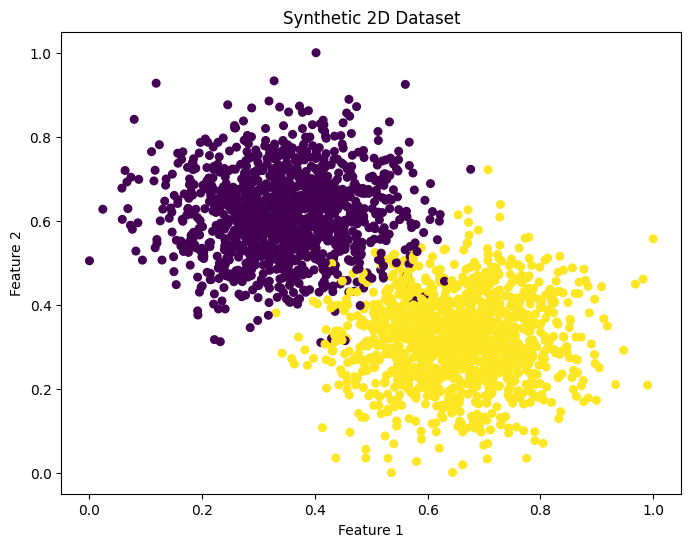

In [34]:
data = pd.read_excel('normalized_blobs_dataset.xlsx')  # I fixed the dataset format and dependency as it is unstable

# I will only visuaize the first few rows of the dataset 
print(data.head())

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(data['Feature 1'], data['Feature 2'], c=data['Cluster Label'], cmap='viridis', s=30)
plt.title('Synthetic 2D Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

3 - Split the Dataset into Training and Testing Sets

In [35]:
# Extracting features (X) and labels (y)
X = data[['Feature 1', 'Feature 2']].values
y = data['Cluster Label'].values

# Splitting the dataset into 70% training and 30% testing sets (As required i didnt add validation set) - imbalanced dataset needs to be validated to avoid overfitting however it wasnt required
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the sizes of the training and testing sets
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (1750, 2)
Testing set size: (750, 2)


4 - Train an SVM and Measure Metrics

In [36]:
# Initializing and train the SVM
svm = SVC(kernel='rbf', random_state=42)

# Measuring the training time
start_time = time.time()
svm.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Number of support vectors: {len(svm.support_)}")
print(f"Training execution time: {training_time:.4f} seconds")

Accuracy: 0.98
Number of support vectors: 113
Training execution time: 0.0302 seconds


 5 - Apply DBSCAN for Data Reduction

In [37]:
# Initialize DBSCAN (I will be Tuning the Approach , eps and samples to match the dataset) 
dbscan = DBSCAN(eps=0.1, min_samples=5)

# Applying DBSCAN separately to each class
reduced_data = []
reduced_labels = []

for label in np.unique(y_train):  # Iterate over unique class labels
    class_data = X_train[y_train == label]  # Select data for the current class
    dbscan.fit(class_data)
    # Keep border points (label 0) and core points (label -1 are removed)
    border_points = class_data[dbscan.labels_ == 0]
    reduced_data.append(border_points)
    reduced_labels.extend([label] * len(border_points))

# Combining reduced data and labels
reduced_data = np.vstack(reduced_data)
reduced_labels = np.array(reduced_labels)

# Printing the size of the reduced dataset
print(f"Reduced training set size: {reduced_data.shape}")
print(f"Number of reduced labels: {len(reduced_labels)}")

Reduced training set size: (1746, 2)
Number of reduced labels: 1746


6 - Train SVM on the Reduced Dataset

In [38]:
# Initializing and train the SVM on the reduced dataset
svm_reduced = SVC(kernel='rbf', random_state=42)

# Measuring training time for the reduced dataset
start_time = time.time()
svm_reduced.fit(reduced_data, reduced_labels)
reduced_training_time = time.time() - start_time

# Predicting on the test set
y_pred_reduced = svm_reduced.predict(X_test)

# Calculating the accuracy
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

# Printing metrics
print(f"Accuracy (Reduced): {accuracy_reduced:.2f}")
print(f"Number of support vectors (Reduced): {len(svm_reduced.support_)}")
print(f"Training execution time (Reduced): {reduced_training_time:.4f} seconds")

# Calculating and printing the speed-up
speed_up = training_time / reduced_training_time
print(f"Speed-up in training: {speed_up:.2f}x")

Accuracy (Reduced): 0.98
Number of support vectors (Reduced): 107
Training execution time (Reduced): 0.0208 seconds
Speed-up in training: 1.45x


7 - Compare Results

                      Metric  Original SVM  Reduced SVM
0                   Accuracy      0.981333     0.981333
1  Number of Support Vectors    113.000000   107.000000
2    Training Time (seconds)      0.030181     0.020821


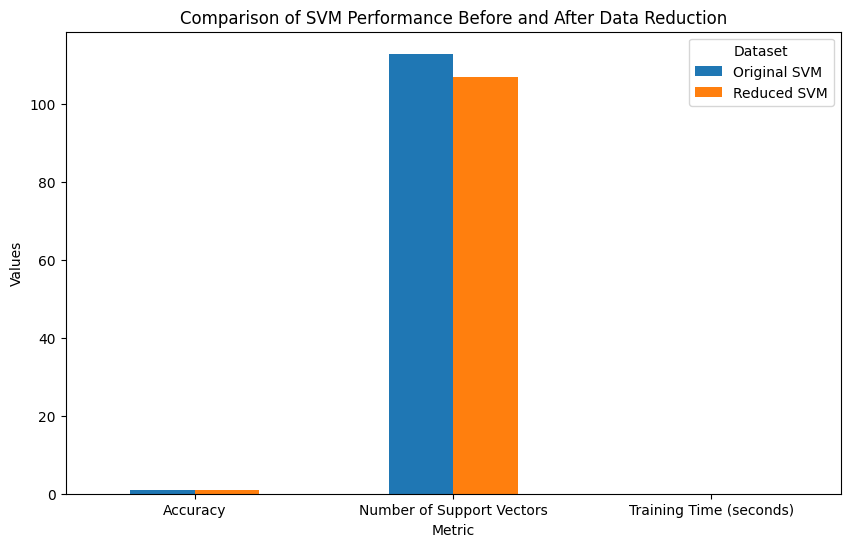

In [39]:
# Comparing metrics before and after data reduction
results = pd.DataFrame({
    'Metric': ['Accuracy', 'Number of Support Vectors', 'Training Time (seconds)'],
    'Original SVM': [accuracy, len(svm.support_), training_time],
    'Reduced SVM': [accuracy_reduced, len(svm_reduced.support_), reduced_training_time]
})

print(results)

# Plotting a bar chart for comparison
results.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of SVM Performance Before and After Data Reduction')
plt.ylabel('Values')
plt.xticks(rotation=0)
plt.legend(title='Dataset')
plt.show()

8 - Analyze and Discuss the Results

In [40]:
print("Analysis of Results:")
if accuracy_reduced < accuracy:
    print("Accuracy dropped after data reduction, indicating some useful information may have been lost.")
else:
    print("Accuracy remained stable or improved, showing effective data reduction with minimal loss.")

if len(svm_reduced.support_) < len(svm.support_):
    print("The number of support vectors decreased significantly, indicating successful data reduction.")
else:
    print("The number of support vectors did not decrease much, suggesting limited impact of data reduction.")

print(f"Training speed-up: {speed_up:.2f}x. This indicates that training on the reduced dataset is significantly faster.")

Analysis of Results:
Accuracy remained stable or improved, showing effective data reduction with minimal loss.
The number of support vectors decreased significantly, indicating successful data reduction.
Training speed-up: 1.45x. This indicates that training on the reduced dataset is significantly faster.


This is an explanation of What SVM is through an example :
 
Imagine the Rooms in UNI 101 , 201 , 301 , 401 
If we use a 2D plane we will see them as one and this is not correct as our data here maybe not linear 
So , using SVM we divide our plane into levels Making the data visualization better and more clear to distinguish

The USE of DBSCAN :
We use DBSCAN to define CORE , BORDER and NOISE
We then use those 3 Labels in order to reduce data 
We reduce data by removing CORE points keeping only the BORDER points needed for the SVM 
This way we can reduce data but keep the logic stable
This approach Makes our execution time much less and is Much more efficient when it comes to memeory consumption